# 1d VanLeer Advection (Bodenheimer et al, Section 6.3.2)

At the end of __1c Advection__, we saw that a straight evaluation of the advection equation leads to problems, in the form of "ringing" at sharp transitions in the advected quantity, so let's pick up the definitions from there:

Standard libraries, and a bunch of definitions.  We have a new notebook and a new python kernel now, so nothing is remembered from __1c Advection__:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def adams_bashforth(f0,f1,dfdt,dt):
    return f1+dt*(1.5*dfdt(f1)-0.5*dfdt(f0))
def coordinates(n):
    ds=2.0*np.pi/n
    x=ds*np.arange(n)
    return ds,x
def IC(x,v,t):
    f=np.sin(x-v*t)
    return f
def Courant(C,v,ds):
    dt=C/np.max(v/ds)
    return dt
def deriv(f,ds,axis=0,order=2):
    return (np.roll(f,-1,axis)-np.roll(f,+1,axis))/(2.0*ds)
def dfdt(f):
    return -V*deriv(f,ds,0)
def square_wave(x,v,ds,t):
    f=IC(x,v,t)
    return np.tanh((S/ds)*f)

Now we can repeat the plot showing the problem, in a wide figure:

In [4]:
def wide_fig(title='',s=''):
    if title=='':
        title='{}  Courant={:.2f}  steepness={}'.format(s,C,S)
    plt.figure(figsize=(14,4))
    plt.title(title);

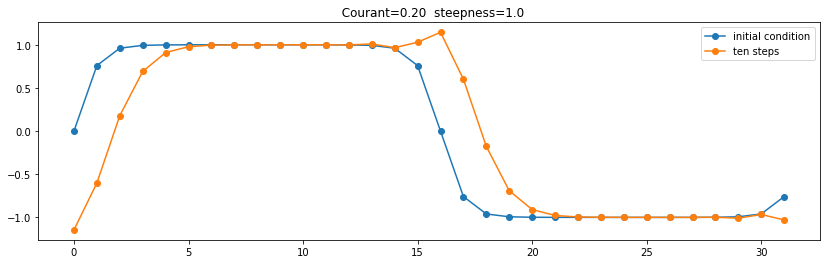

In [5]:
n=32
C=0.2
S=1.0
V=1.0
nt=10
ds,x=coordinates(n)
dt=Courant(C,V,ds)
sq=square_wave(x,V,ds,0.0)
f0=sq
f1=square_wave(x,V,ds,dt)
wide_fig()
plt.plot(f0,'-o',label='initial condition')
for it in range(nt-1):
    f2=adams_bashforth(f0,f1,dfdt,dt)
    f0=f1
    f1=f2
plt.plot(f2,'-o',label='ten steps')
plt.legend();

This figure above, is basically where we ended in exercise 1c. An overshoot, or ringing, due to the discontinuity that is a composite of all Fourier modes, with the problem that we cannot efficiently evolve features at the grid scale.

### Implementing the VanLeer advection scheme from Section 6.3.2 in the book

The derivative of a function is the central object we are concerned with in this exercise, and much of the course. The atomic operation related to the discretized derivative is obtaining the difference between two adjacent points.
We therefore define a procedure computing the "left slopes" -- the slopes connecting a point with the point on the left hand side and look at the representation for a square wave:

In [6]:
def left_slope(f):
    return f-np.roll(f,1)

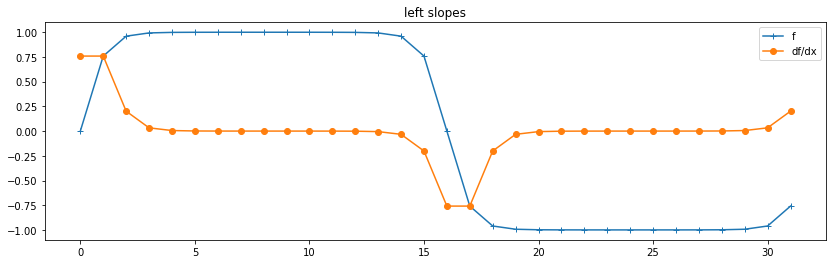

In [7]:
f0=square_wave(x,V,ds,0.0)
ls=left_slope(f0)
wide_fig('left slopes')
plt.plot(f0,'-+',label='f')
plt.plot(ls,'-o',label='df/dx')
plt.legend();

### Cell-centered slopes, with no limiter

Next, we make a function that implement cell-centered slopes, equal to the average of the left and right slopes (the "right slope" connects a point with the next point to the right, and we can get them by simply rolling the left slopes one step):

\begin{equation}
\Delta f_{\rm{Cen}} = f(x + \Delta x) - f(x - \Delta x)
= \frac{1}{2}  [ (f(x + \Delta x) - f(x)) + (f(x) - f(x -  \Delta x)) ]
= \frac{1}{2}   [ \Delta f_{\rm{rs}}  + \Delta f_{\rm{ls}} ]
\end{equation}

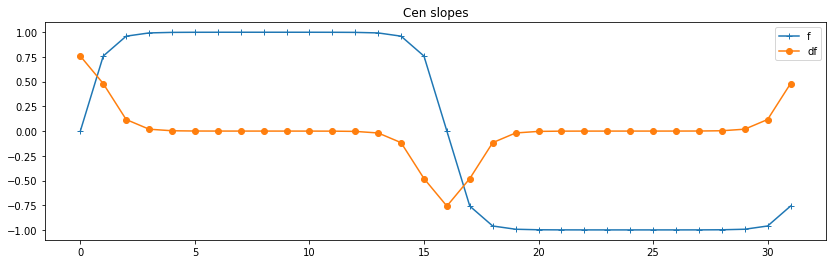

In [8]:
def Cen(ls):
    rs=np.roll(ls,-1)
    return (ls+rs)*0.5
wide_fig('Cen slopes')
f0=square_wave(x,V,ds,0.0)
ls=left_slope(f0)
cs=Cen(ls)
plt.plot(f0,'-+',label='f')
plt.plot(cs,'-o',label='df')
plt.legend();

To better appreciate these slopes, we can plot short lines with these slopes, through the points. The main thing to notice here is that in places where the slope change rapidly, e.g. where the higher derivatives are large, the central slope over / under estimates the slope to either the left or right hand side to such a degree that any transport of a feauture will start to create wiggles -- ringing. This is very apparent when plotting slopes as lines exactly matching how a central slope would extrapolate the function values to the interface between two cells / the mid point bewteen two points.

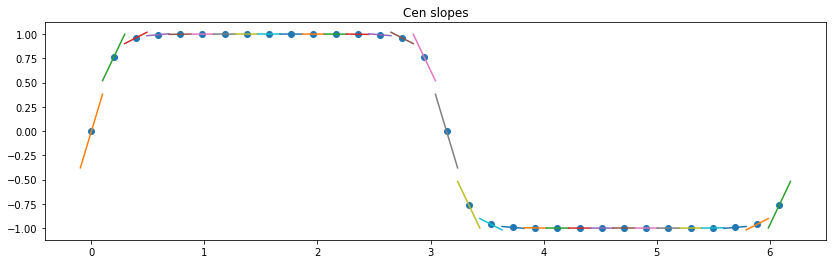

In [9]:
wide_fig('Cen slopes')
f=f0
cs=Cen(ls)
plt.plot(x,f,'o')
for i in range(n):
    xx=[x[i]-ds*0.5,x[i]+0.5*ds]
    yy=[f[i]-0.5*cs[i],f[i]+0.5*cs[i]]
    plt.plot(xx,yy)

### MinMod cell-centered slopes

One of the first improvements that was invented (cf. the VanLeer 1977 reference in the book) was to use the so called _MinMod_ slope, which is the smallest of the left and right slopes ("smallest" disregarding sign).  In addition, one sets (rather arbitrarily) the slope to zero, when the left and right slopes differ:

In [10]:
def MinMod(ls):
    rs=np.roll(ls,-1)
    sign = np.ones(ls.shape)
    sign[np.where(ls < 0.0)] -= 1.0
    sign[np.where(rs < 0.0)] -= 1.0
    return np.minimum(abs(ls),abs(rs))*sign

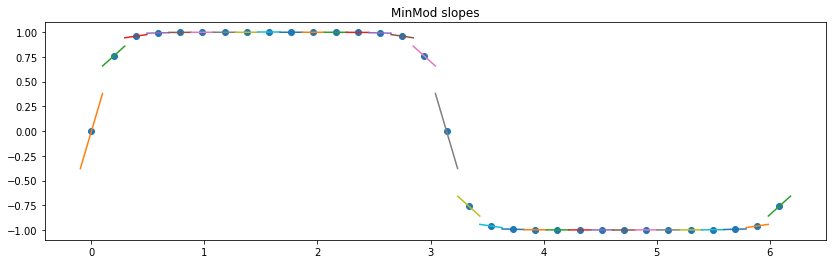

In [11]:
wide_fig('MinMod slopes')
plt.plot(x,f,'o')
cs=MinMod(ls)
for i in range(n):
    xx=[x[i]-ds*0.5,x[i]+0.5*ds]
    yy=[f[i]-0.5*cs[i],f[i]+0.5*cs[i]]
    plt.plot(xx,yy)

### Upstream cell face values of the density

The advection method, by Van Leer, uses slopes inside the upstream cell to estimate the time averaged interface density `d_fl`, which is then multiplied by the (negative) velocity, to get the time derivative. Below we plot a small subsection centered on the transition region, instead of the full $2\pi$ interval.

In [12]:
dt=Courant(C,V,ds)
d_lf = np.roll(f + (ds-V*dt)*cs/ds*0.5,1)

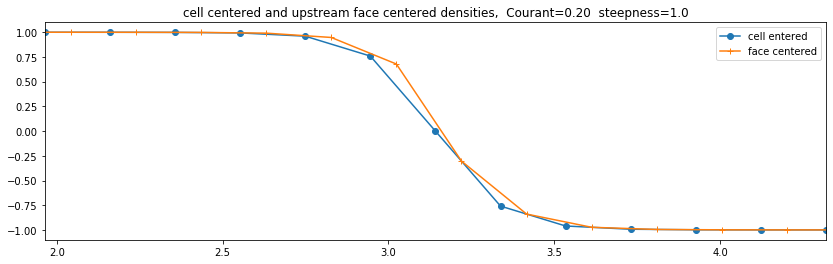

In [13]:
wide_fig(s='cell centered and upstream face centered densities,')
plt.plot(x,f0,'-o',label='cell entered')
plt.plot(x-0.5*ds-0.5*V*dt,d_lf,'-+',label='face centered')
plt.legend()
n1=np.int(6.0/S)
n2=n//2
xl=(x[n2-n1],x[n2+n1])
plt.xlim(xl);

Take a moment to figure out, with the help of the plot, what is meant by "upstream":  If one has such a piecewise linear representation ("reconstruction" is a term often used), then one can
   1. figure out the value at the interface between two cells, at time t, and
   2. figure out the value at the interface at time t+dt (by following the slope)
   
But what one really wants is the average value over time, and since the slope is linear, it is the mean of the two, and that -- again -- is the same as the value at the time `dt/2`, if the problem is linear (as it is, in this approximation).

Alternatively, one can think of it as figuring out what is the slope inside the cell, and then see how much is transported across the cell interface in a timestep `dt`. This is a _triangle_, and the average height of a triangle is exactly ad the midpoint -- `dt/2`

Got it? Otherwise, revisit the book and the slides.

### Collect steps into a time derivative function

The slope is computed by the function `Slope`, which may be set to `Cen` or `MinMod`. It takes as an input the left slope `ls`. Notice how further down, when computing the flux across the interface this slope is divided by ds to get the derivative, and therefore the flux. The flux is the (positive) change of values through an interface per length. To find the change in a cell, we have to add what is coming in from the left and subtract what is leaving to the right.

In [14]:
Slope=Cen
def dfdt(f):
    ls = left_slope(f)
    cs = Slope(ls)
    flux = V*(f + (ds-V*dt)*cs/ds*0.5)
    return (np.roll(flux,1)-flux)/ds

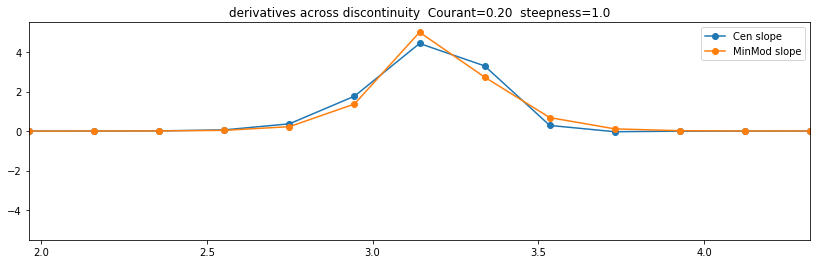

In [15]:
S=1.0
sq=square_wave(x,V,ds,0.0)
wide_fig(s='derivatives across discontinuity')
for Slope in (Cen,MinMod):
    if (Slope==MinMod):
        label='MinMod slope'
    if (Slope==Cen):
        label='Cen slope'
    plt.plot(x,dfdt(sq),'-o',label=label)
    plt.xlim(xl);
plt.legend();

### First order time stepping

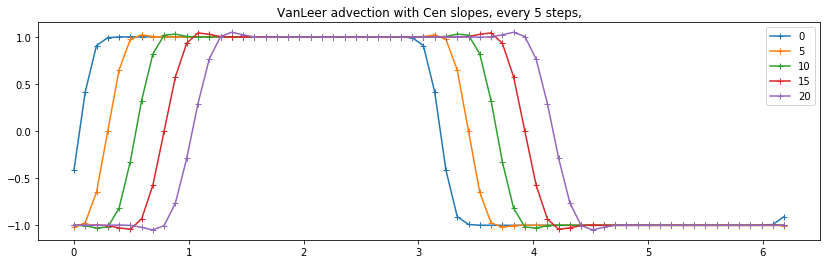

In [16]:
n=64
C=0.5
ds,x=coordinates(n)
dt=Courant(C,V,ds)
f=square_wave(x,V,ds,0.0)

wide_fig('VanLeer advection with Cen slopes, every 5 steps,')
Slope=Cen
for i in range(21):
    f=f+dt*dfdt(f)
    if i%5==0:
        plt.plot(x,f,'-+',label=i)
plt.legend();

It doesn't look all that bad, but one can see a weak tendency for "overshoot", especially after zooming in:

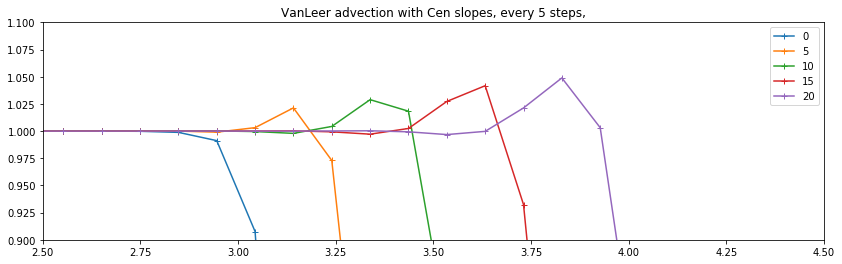

In [17]:
n=64
C=0.5
ds,x=coordinates(n)
dt=Courant(C,V,ds)
f=square_wave(x,V,ds,0.0)

wide_fig('VanLeer advection with Cen slopes, every 5 steps,')
Slope=Cen
for i in range(21):
    f=f+dt*dfdt(f)
    if i%5==0:
        plt.plot(x,f,'-+',label=i)
plt.xlim(2.5,4.5); plt.ylim(0.9,1.1)
plt.legend();

### Compare Cen and MinMod slopes after a full period

After a full period, the overshoot has become clearly visible for the _Cen_ (central, simple derivative) slopem while the _MinMod_ suppress ringing at the cost of diffusion:

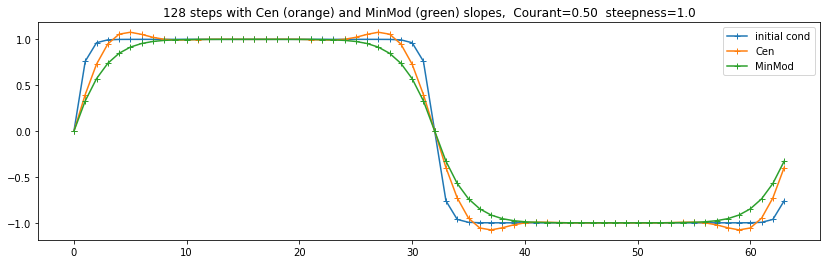

In [18]:
n=64
C=0.5
ds,x=coordinates(n)
dt=Courant(C,V,ds)
sq=square_wave(x,V,ds,0.0)

nt=np.int(n/C+0.5)
wide_fig(s='{} steps with Cen (orange) and MinMod (green) slopes,'.format(nt))
plt.plot(sq,'-+',label='initial cond')
for Slope in (Cen,MinMod):
    f=np.copy(sq)
    for i in range(nt):
        f=f+dt*dfdt(f)
    if (Slope==MinMod):
        label='MinMod'
    if (Slope==Cen):
        label='Cen'
    plt.plot(f,'-+',label=label)
plt.legend();
#pl.savefig("advection_vl.png")

The `savefig` command write the figure out to an `advection_vl.png` file and is useful if we would like to export the plot to e.g. a document.

#### __Task:__

Implement the `MonCen` slope limiter, mentioned in Section 6.3.2 in the book, and extend the comparison, so all three results are compared

In [19]:
def left_slope(f):
    return f-np.roll(f,1)

def Cen(ls):
    rs=np.roll(ls,-1)
    return (ls+rs)*0.5

def MonCen(ls):
    rs=np.roll(ls,-1)
    prod=rs*ls
    cs = np.zeros(ls.shape)
    w = np.where(prod>0)
    cs[w]=2*prod[w]/(rs[w]+ls[w])
    return cs

Slope=MonCen
def dfdt(f):
    ls = left_slope(f)
    cs = Slope(ls)
    flux = V*(f + (ds-V*dt)*cs/ds*0.5)
    return (np.roll(flux,1)-flux)/ds

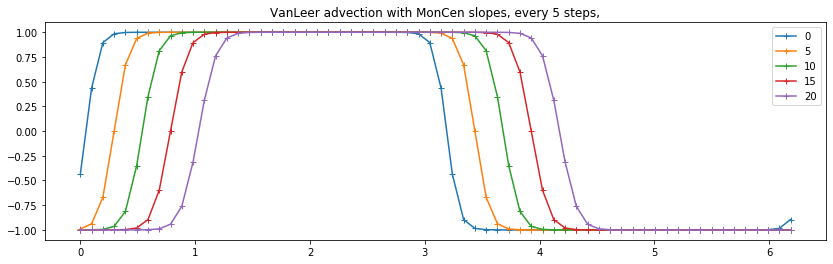

In [20]:
n=64
C=0.5
ds,x=coordinates(n)
dt=Courant(C,V,ds)
f=square_wave(x,V,ds,0.0)

wide_fig('VanLeer advection with MonCen slopes, every 5 steps,')
Slope=MonCen
for i in range(21):
    f=f+dt*dfdt(f)
    if i%5==0:
        plt.plot(x,f,'-+',label=i)
plt.legend();

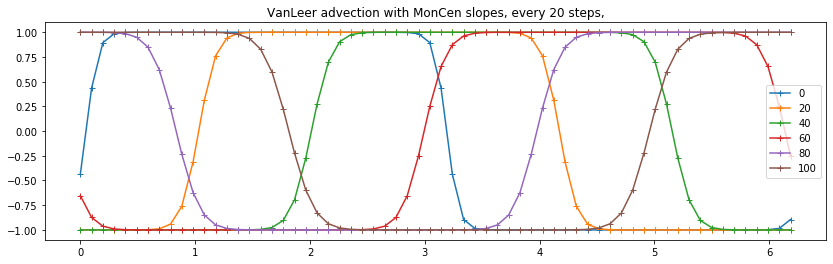

In [21]:
n=64
C=0.5
ds,x=coordinates(n)
dt=Courant(C,V,ds)
f=square_wave(x,V,ds,0.0)

wide_fig('VanLeer advection with MonCen slopes, every 20 steps,')
Slope=MonCen
for i in range(120):
    f=f+dt*dfdt(f)
    if i%20==0:
        plt.plot(x,f,'-+',label=i)
plt.legend();

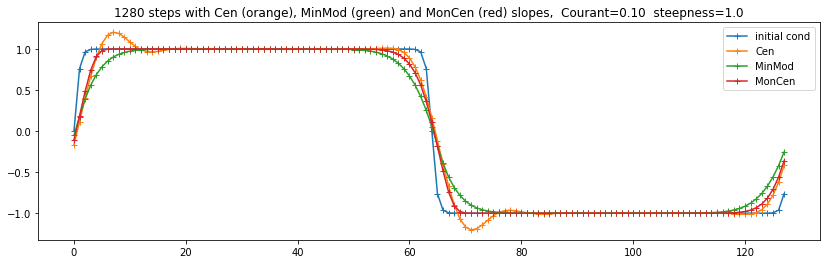

In [28]:
n=128
C=0.1
ds,x=coordinates(n)
dt=Courant(C,V,ds)
sq=square_wave(x,V,ds,0.0)

nt=np.int(n/C+0.5)
wide_fig(s='{} steps with Cen (orange), MinMod (green) and MonCen (red) slopes,'.format(nt))
plt.plot(sq,'-+',label='initial cond')
for Slope in (Cen,MinMod, MonCen):
    f=np.copy(sq)
    for i in range(nt):
        f=f+dt*dfdt(f)
    if (Slope==MinMod):
        label='MinMod'
    if (Slope==Cen):
        label='Cen'
    if (Slope==MonCen):
        label='MonCen'
    plt.plot(f,'-+',label=label)
plt.legend();
plt.savefig("advection_all.png")

## Text for answer
We see that this is less diffusive than the MinMod and more accurate and doesn't ring like the centered method, since, at the top where one slope is 0 and the other one goes strongly up/down, we set the derivative to zero.

Overall it is nice and stable, even though it doesn't hit it exactly and does diffuse a bit. But that was all we were hoping for so that is great! I'd guess this difference especially comes into play when you do a lot of time steps!

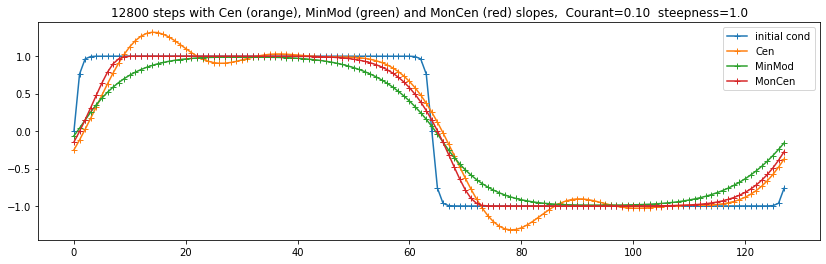

In [29]:
n=128
C=0.1
ds,x=coordinates(n)
dt=Courant(C,V,ds)
sq=square_wave(x,V,ds,0.0)

nt=np.int(n/C+0.5)*10
wide_fig(s='{} steps with Cen (orange), MinMod (green) and MonCen (red) slopes,'.format(nt))
plt.plot(sq,'-+',label='initial cond')
for Slope in (Cen,MinMod, MonCen):
    f=np.copy(sq)
    for i in range(nt):
        f=f+dt*dfdt(f)
    if (Slope==MinMod):
        label='MinMod'
    if (Slope==Cen):
        label='Cen'
    if (Slope==MonCen):
        label='MonCen'
    plt.plot(f,'-+',label=label)
plt.legend();

This look really nice as well!

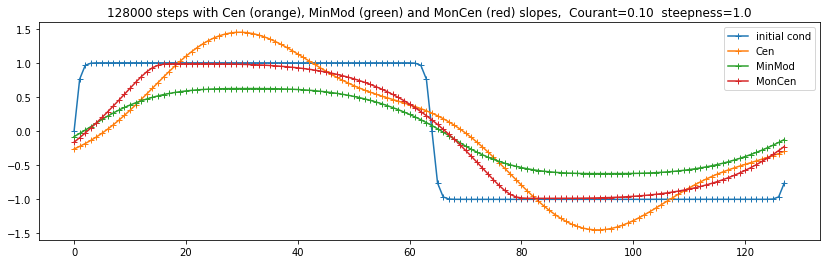

In [31]:
n=128
C=0.1
ds,x=coordinates(n)
dt=Courant(C,V,ds)
sq=square_wave(x,V,ds,0.0)

nt=np.int(n/C+0.5)*100
wide_fig(s='{} steps with Cen (orange), MinMod (green) and MonCen (red) slopes,'.format(nt))
plt.plot(sq,'-+',label='initial cond')
for Slope in (Cen,MinMod, MonCen):
    f=np.copy(sq)
    for i in range(nt):
        f=f+dt*dfdt(f)
    if (Slope==MinMod):
        label='MinMod'
    if (Slope==Cen):
        label='Cen'
    if (Slope==MonCen):
        label='MonCen'
    plt.plot(f,'-+',label=label)
plt.legend();
# plt.savefig("advection_all.png")

Here the leading wave edge is clearly visible and is a bit different from the trailing wave edge

## Let's also compare the slope

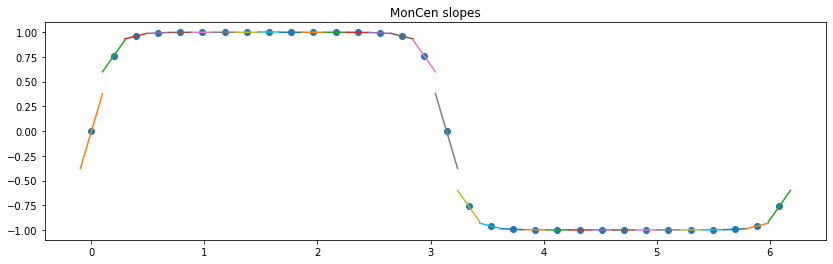

In [38]:
n=32
ds,x=coordinates(n)
f0=square_wave(x,V,ds,0.0)
ls=left_slope(f0)
wide_fig('MonCen slopes')
f=f0
plt.plot(x,f,'o')
cs=MonCen(ls)
for i in range(n):
    xx=[x[i]-ds*0.5,x[i]+0.5*ds]
    yy=[f[i]-0.5*cs[i],f[i]+0.5*cs[i]]
    plt.plot(xx,yy)

This is absolute fantastic, even though there are small discrepancies at either start/end of the transition/steep zone, so the monotization really works!

#### __Absalon turn-in__

Upload the notebook with the advection figure, and a pdf of the notebook, and write a short text -- inside the notebook -- commenting on the figure